In [1]:
import os # to get the path of the files
from glob import glob
import shutil

import sys # to get the arguments
import numpy as np # to work with arrays
import pandas as pd # to work with dataframes
import gc # to clean the memory

import itertools # to work with iterators
from tqdm import tqdm # to show the progress bar
import matplotlib.pyplot as plt # to show the images
from glob import glob # to get the path of the files
import PIL.Image as Image # to work with images
import numpy as np # to work with arrays
import matplotlib.pyplot as plt # to show the images

import torch # to build the model
from torch import nn # to build the model
import torch.nn.functional as F # to build the model
# import torchvision.transforms as transforms # to build the model
from torchvision import transforms,datasets,utils
import timm # to build the model

from torch.utils.data import Dataset, DataLoader # to build the model
from torch.utils.data.sampler import SequentialSampler, RandomSampler # to build the model
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau # to build the model

#defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# remove warnings
import warnings
warnings.filterwarnings('ignore')

cuda


In [2]:
# we will make folder with some images that are similar to the images in the dataset and some images that are not

folders =['/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Test/Normal',
          '/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Test/bacteria',
          '/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Test/virus',
          '/kaggle/input/intel-image-classification/seg_train/seg_train/forest',
          '/kaggle/input/intel-image-classification/seg_train/seg_train/buildings',
          '/kaggle/input/intel-image-classification/seg_train/seg_train/sea']

def make_test_images(folders):
    '''
  Folders is a collection of directories housing various images. 
  The initial three folders consist of images that closely resemble those in the dataset,
  while the remaining folders contain images that differ significantly.
  Our objective is to select ten images from each folder. 
  To achieve this, we will create two separate directories—one for the similar images and another for the dissimilar images
    '''
    # make the folders
    os.mkdir('test_images')
    os.mkdir('test_images/sim')
    os.mkdir('test_images/diff')

    for idx in tqdm(range(len(folders))):
        if idx < 3:
            imges = glob(folders[idx]+'/*.jpeg')
            print('sim ',len(imges))
            images_10 = np.random.choice(imges,10)
            for image in images_10:
                shutil.copy(image,'test_images/sim')
        else:
            imges = glob(folders[idx]+'/*.jpg')
            print('diff ',len(imges))
            images_10 = np.random.choice(imges,10)
            for image in images_10:
                shutil.copy(image,'test_images/diff')

make_test_images(folders)

 17%|█▋        | 1/6 [00:00<00:00,  6.19it/s]

sim  100
sim  100


 50%|█████     | 3/6 [00:00<00:00, 10.65it/s]

sim  100
diff  2271


100%|██████████| 6/6 [00:00<00:00,  8.99it/s]

diff  2191
diff  2274


In [3]:
# defining the paths eatch dataset has number of classes in folders so we will use all of them
path1 = '/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Train'
path2 = '/kaggle/input/intel-image-classification/seg_train/seg_train'

# defining the classes
classes1 = os.listdir(path1)
classes2 = os.listdir(path2)

# get pathes of the images in first dataset
images1 = []
for i in classes1:
    images1.append(glob(os.path.join(path1,i,'*.jpeg')))
images1 = list(itertools.chain(*images1))

# get pathes of the images in second dataset
images2 = []
for i in classes2:
    images2.append(glob(os.path.join(path2,i,'*.jpg')))
images2 = list(itertools.chain(*images2))


In [4]:
# get the number of images in each dataset
print('Number of images in first dataset: ',len(images1))
print('Number of images in second dataset: ',len(images2))


Number of images in first dataset:  3900
Number of images in second dataset:  14034


In [5]:
len(images2)

14034

In [6]:
img_size = 224 # the size of the images
import cv2

# defining the dataset class
class Lung(Dataset):
    def __init__(self,images1,images2,transform=None):
        self.images1 = images1
        self.images2 = images2
        self.transform = transform

    def __len__(self):
        return len(self.images1) + len(self.images2)

    def __getitem__(self,idx):
        if idx < len(self.images1):
            image = Image.open(self.images1[idx]).convert('RGB')
            label = 1
        else:
            image = Image.open(self.images2[idx - len(self.images1)]).convert('RGB')
            label = 0

        if self.transform:
            image = self.transform(image)

        return image,label


# data transforms
transforms_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_valid = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
dataset = Lung(images1,images2,transform=transforms_train)

# split the data into train and valid
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

# defining the dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=4)


In [8]:
for image,label in train_loader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([128, 3, 224, 224])
torch.Size([128])


In [9]:
lab = []
for image,label in train_loader:
    lab
    break

In [10]:
# plot some images
def sample(dl):
    images,labels = next(iter(dl))
    fig = plt.figure(figsize=(16,16))
    for i in range(16):
        ax = fig.add_subplot(4,4,i+1,xticks=[],yticks=[])
        ax.imshow(np.transpose(images[i].numpy(),(1,2,0)))
        ax.set_title(labels[i])
    plt.show()

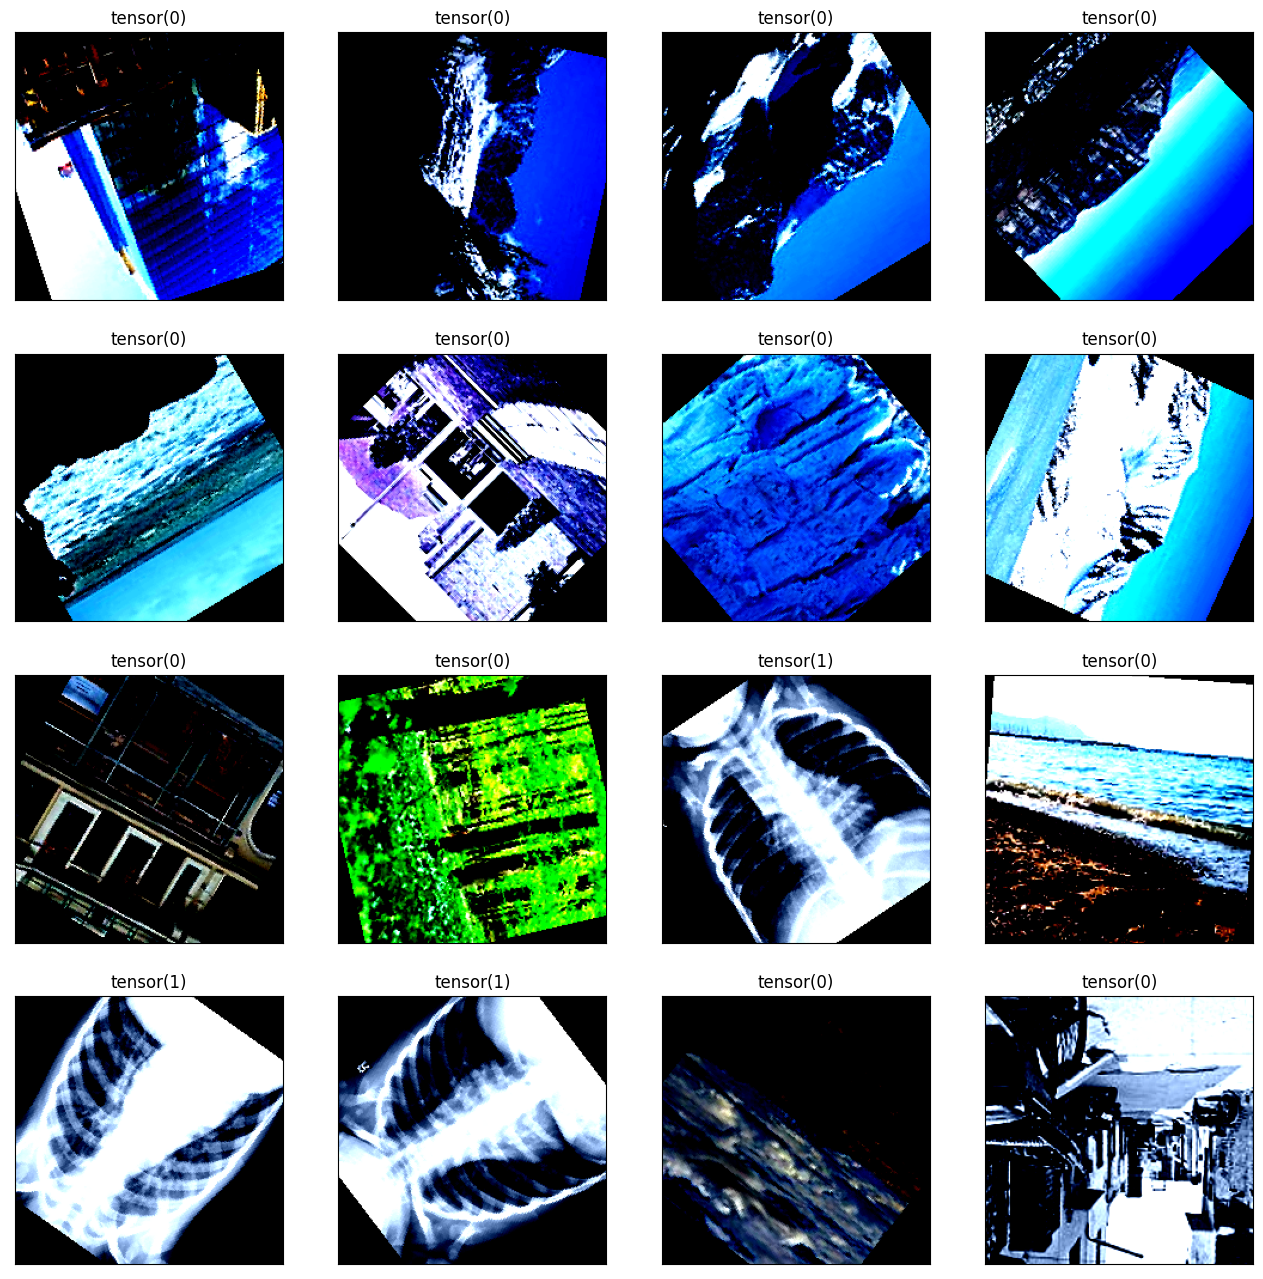

In [11]:
sample(train_loader)

In [12]:
test_ds = datasets.ImageFolder(root = '/kaggle/working/test_images',
                                    transform = transforms_valid)
# test_ds.targets = [1 if x==0 else 0 for x in test_ds.targets]

test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

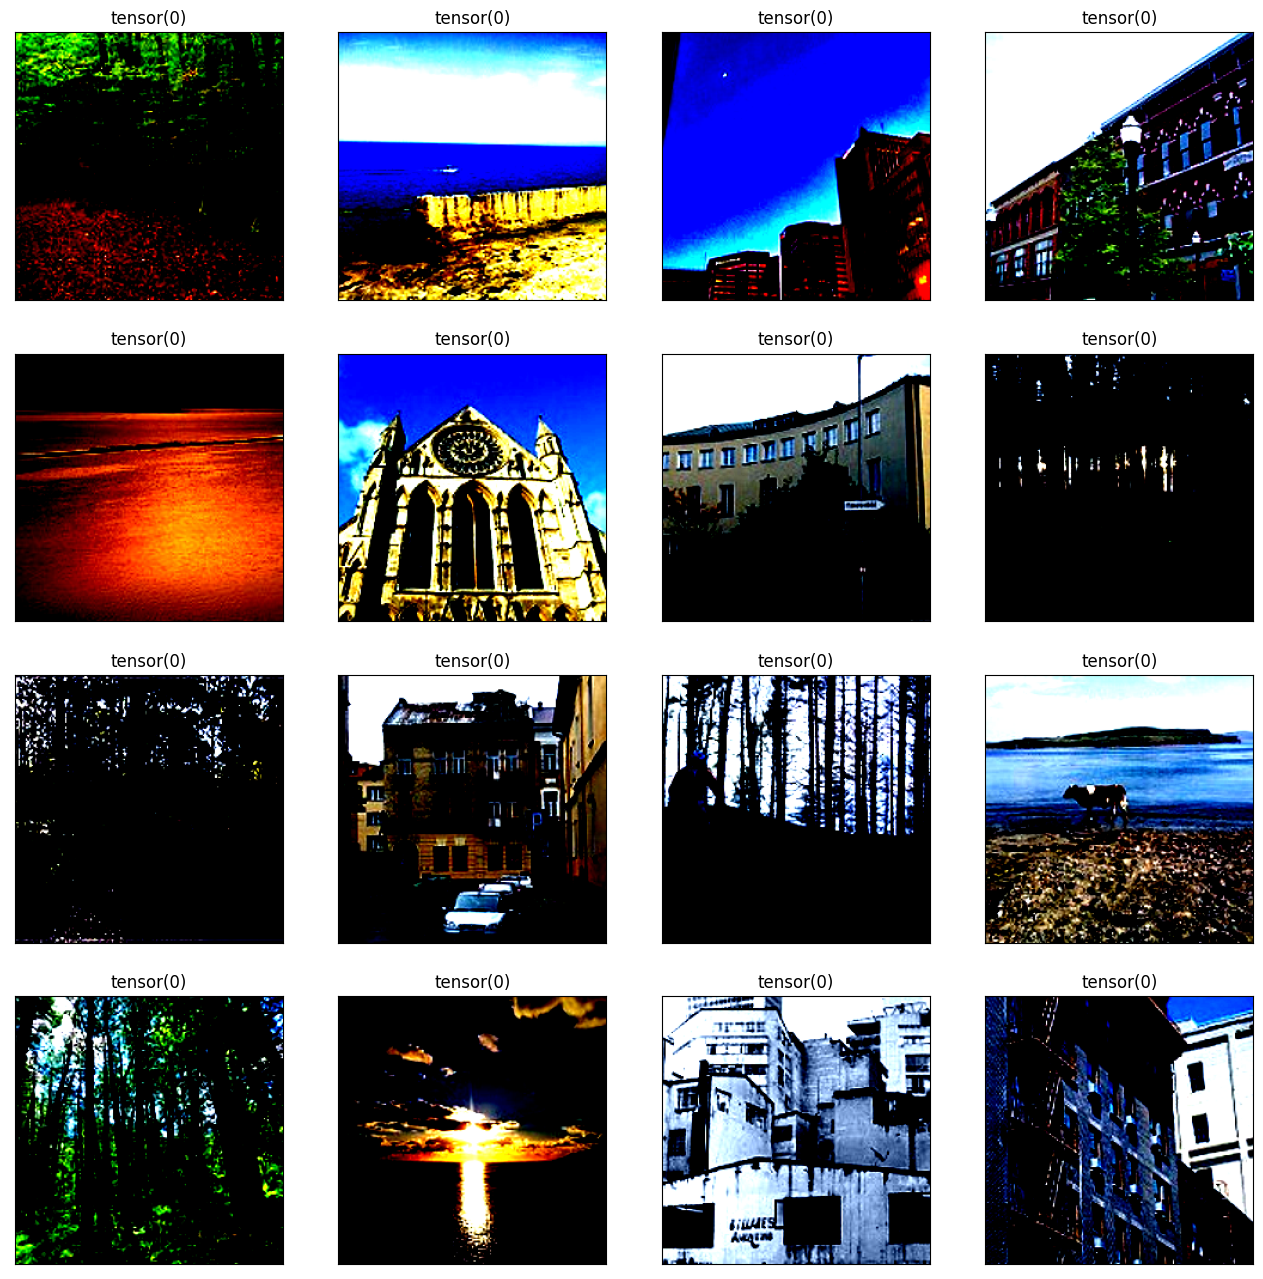

In [13]:
sample(test_dl)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        print(n_features)
        self.model.head = nn.Linear(n_features, 2)
        # stop the model from training
        for param in self.model.parameters():
            param.requires_grad = False
        # train the last  5 layer
        for param in self.model.blocks[-5:].parameters():
            param.requires_grad = True
        for param in self.model.head.parameters():
            param.requires_grad = True
    def forward(self, x):
        x = self.model(x)
        # add softmax
        x = F.softmax(x, dim=1)
        
        return x

In [15]:
discriminator = Discriminator(model_name='vit_base_patch16_224', pretrained=True).to(device)


768


In [16]:
!pip install torchsummary
# summary of the model
from torchsummary import summary
summary(discriminator, input_size=(3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
         LayerNorm-6             [-1, 197, 768]           1,536
            Linear-7            [-1, 197, 2304]       1,771,776
           Dropout-8         [-1, 12, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
          Dropout-10             [-1, 197, 768]               0
        Attention-11             [-1, 197, 768]               0
         Identity-12             [-1, 197, 768]               0
         Identity-13             [-1, 197, 768]               0
        LayerNorm-14             [-1, 1

In [17]:
criterion = nn.CrossEntropyLoss()


In [18]:
# training function
def train(model, train_dl, valid_dl, criterion,epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode="min", verbose=True)

    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        # train
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_dl):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss/len(train_dl)
        train_losses.append(train_loss)
        # validate
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for images, labels in tqdm(valid_dl):
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                valid_loss += loss.item()
            valid_loss = valid_loss/len(valid_dl)
            valid_losses.append(valid_loss)
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}.. "
              f"Valid loss: {valid_loss:.3f}")
        #save the best model
        if valid_loss == min(valid_losses):
            torch.save(model.state_dict(), 'best_model.pt')
        # update the learning rate
        scheduler.step(valid_loss)
    return train_losses, valid_losses

In [19]:
# train the model
epochs = 10
train_losses1, valid_losses1 = train(discriminator, train_loader, valid_loader, criterion,epochs)

100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch 1/10.. Train loss: 0.316.. Valid loss: 0.314


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch 2/10.. Train loss: 0.313.. Valid loss: 0.313


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch 3/10.. Train loss: 0.313.. Valid loss: 0.313


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch 4/10.. Train loss: 0.313.. Valid loss: 0.313


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch 5/10.. Train loss: 0.313.. Valid loss: 0.313


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Epoch 6/10.. Train loss: 0.313.. Valid loss: 0.315
Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch 7/10.. Train loss: 0.314.. Valid loss: 0.313


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch 8/10.. Train loss: 0.313.. Valid loss: 0.313


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Epoch 9/10.. Train loss: 0.313.. Valid loss: 0.313


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Epoch 10/10.. Train loss: 0.313.. Valid loss: 0.313
Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.


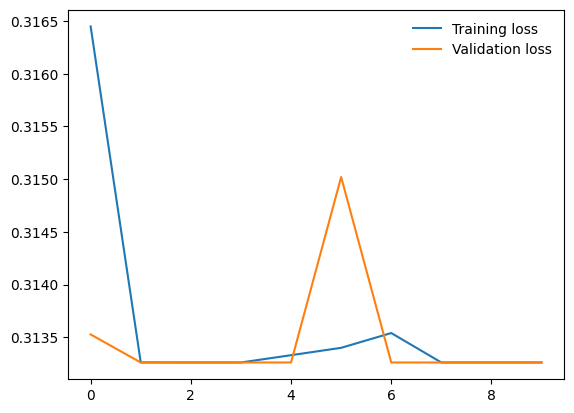

In [20]:
# plot the losses
plt.plot(train_losses1, label='Training loss')
plt.plot(valid_losses1, label='Validation loss')
plt.legend(frameon=False)


In [21]:
# load the best model
discriminator.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [22]:
def test(model, test_dl):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(test_dl):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            correct += (top_class == labels.view(*top_class.shape)).sum().item()
    test_loss = test_loss/len(test_dl)
    print(f"Test loss: {test_loss:.3f}")
    print(f"Accuracy: {correct/len(test_dl):.3f}")

In [23]:
test(discriminator, test_dl)


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

Test loss: 0.313
Accuracy: 57.000


In [30]:
# print classification report
y_true = []
y_pred = []
discriminator.eval()
with torch.no_grad():
    for images, labels in tqdm(test_dl):
        # change the labels
#         labels = 1 - labels
        images, labels = images.to(device), labels.to(device)
        log_ps = discriminator(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(top_class.cpu().numpy())
    y_pred_ = [int(i) for i in y_pred]


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


In [31]:
len(y_pred_)

57

In [32]:
int(y_pred[0])

0

In [33]:
len(y_true)

57

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        28

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57

